<a href="https://colab.research.google.com/github/stefanbringuier/randomonium/blob/main/notebooks/PyCalphadExample_Blog_PhaseDiagram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

| Notebook Information |                                         |
|:---------------------|:----------------------------------------|
| **Author**           | Stefan Bringuier                        |
| **Blog Post**        | [diracs-student.blogspot.com](https://diracs-student.blogspot.com/2023/05/calculating-phase-diagrams.html)            |
| **License**          | CC BY 4.0                               |
| **Date**             | 2023-05-04                              |
| **Environment**      | Google Colab Notebook                    |



## Installing Pycalphad

The first thing is we need to install the [pycalphad]() library. This is done simply by using the python package manager.

In [1]:
! pip install -U pip setuptools &> /dev/null
! pip install -U pycalphad &> /dev/null

## Thermodynamic database
The CALPHAD method requires a thermochemical database which provides the neccessary thermodynamic functions (ex., enthalpy of mixing) to construct the Gibbs free energy expression for the phases being included.

The whole field of CALPHAD method is pretty much the research and development into constructing more complete and accurate databases.

Here I'm going to leverage the [Thermodynamic Database Database (TDBDB)](https://avdwgroup.engin.brown.edu), what a name! But the file I'm going to use is a generic database, COST507, which is floating around every where. The specific version I'm using is a modified version by Bocklund.

I'm going to download the file into the colab environment.

In [2]:
import urllib.request

url = "https://gist.githubusercontent.com/bocklund/c4714ddbc0500c78e6fe255a763e7550/raw/7ac446112c2592d6d69b6beeddbe1b70f5e3a879/COST507-modified.tdb"
filename = "cost507.tdb"
urllib.request.urlretrieve(url,filename)


('cost507.tdb', <http.client.HTTPMessage at 0x7f6e93811de0>)

## Defining phases

I'm going to focus on the Al-Si binary system. We need to first import the database and then and see which phases are represented in the database along with what solution models.

In [3]:
from pycalphad import Database
# Load database and  display phases available
db = Database("cost507.tdb")

In [9]:
phases = db.phases.keys()
cu_ni_phases = [phase for phase in phases if 'CU' in str(db.phases[phase].constituents) and 'NI' in str(db.phases[phase].constituents)]
print('Phases for the Cu-Ni system:')
print(*cu_ni_phases,sep="\n")

Phases for the Cu-Ni system:
LIQUID
BCC_A2
BCC_B2
FCC_A1
HCP_A3
LAVES_C36


So we see that there are a few phases that can be represented by the Cu-Ni system. However we may actually decide on which phases we want to include into our prediction of the phase diagram, this requires knowledge of the problem at hand because some of these maybe hypothetical.

> **Note**: The `.tdb` standard has some wonky notation and standards. One being that the letters in the chemical symbols are all capitalized.


Lets first start with structures/phases we know are likely:

In [26]:
use_phases = ['LIQUID','FCC_A1','HCP_A3','LAVES_C36']

The first is `LIQUID` which is self-explanitory, the `FCC_A1` is your standard FCC unit cell (spacegroup:  Fm3m, 225) and `HCP_A3` is a hexagonal unit cell which can be for pure metals, solid solutions, or intermetallics (i.e. stoichiometric metal alloys)

Skipped FCC_A1 not active
Skipped HCP_A3 not active


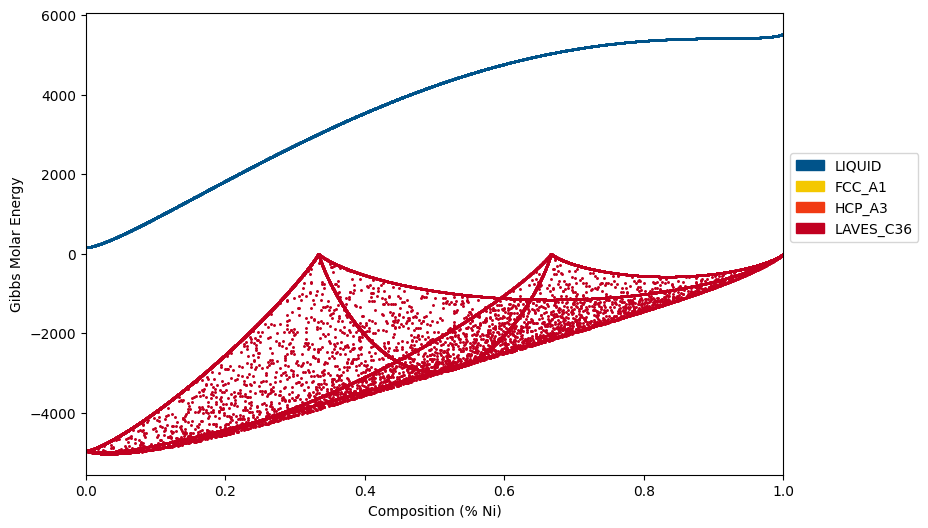

In [28]:
import matplotlib.pyplot as plt
from pycalphad import calculate, variables as v
from pycalphad.plot.utils import phase_legend

# Get the colors that map phase names to colors in the legend
legend_handles, color_dict = phase_legend(use_phases)
fig = plt.figure(figsize=(9,6))
ax = fig.gca()

# Loop over phases, calculate the Gibbs energy
for phase_name in use_phases:
    try:
      result = calculate(db, ['CU', 'NI'], phase_name, P=101325, T=300, output='GM')
      ax.scatter(result.X.sel(component='NI'), result.GM, marker='.', s=5, color=color_dict[phase_name])
    except:
      print(f"Skipped {phase_name} not active")
# Format the plot
ax.set_xlabel('Composition (% Ni)')
ax.set_ylabel('Gibbs Molar Energy')
ax.set_xlim((0, 1))
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.6))
plt.show()

The resulting plot is the Gibbs molar energy for different compositions of Nickel. Also note that in the code we use an exception to ignore phases we selected but are not active/defined for the thermodynmaic conditions. The stable phase is the `LAVES_C36` structure which is 1:2 stoichiometric ratio between the constituent elements (AB2). I forgot how to interpret the multiple points for the gibbs curve of a phase for a given composition.

Now lets try 900K.

Skipped FCC_A1 not active
Skipped HCP_A3 not active


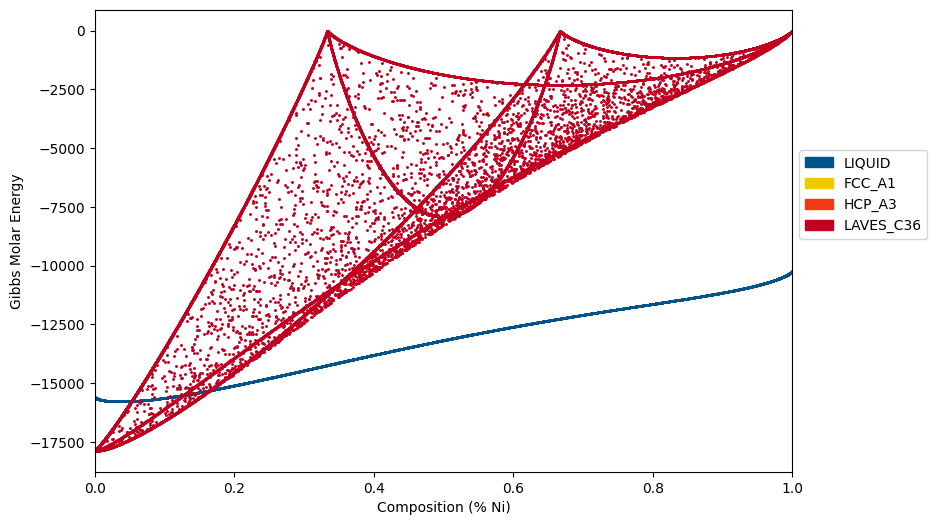

In [30]:
# Get the colors that map phase names to colors in the legend
legend_handles, color_dict = phase_legend(use_phases)
fig = plt.figure(figsize=(9,6))
ax = fig.gca()

for phase_name in use_phases:
    try:
      result = calculate(db, ['CU', 'NI'], phase_name, P=101325, T=600, output='GM')
      ax.scatter(result.X.sel(component='NI'), result.GM, marker='.', s=5, color=color_dict[phase_name])
    except:
      print(f"Skipped {phase_name} not active")

# Format the plot
ax.set_xlabel('Composition (% Ni)')
ax.set_ylabel('Gibbs Molar Energy')
ax.set_xlim((0, 1))
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.6))
plt.show()

Different right? We now see that ≥15.0% Ni the mixture is in a liquid phase, but below this it shows `LAVES_C36` structure.

So lets see what the phase diagram prediction is for the set of phases selected in `use_phases`. I'll span the temperature range 1200-1800 K.

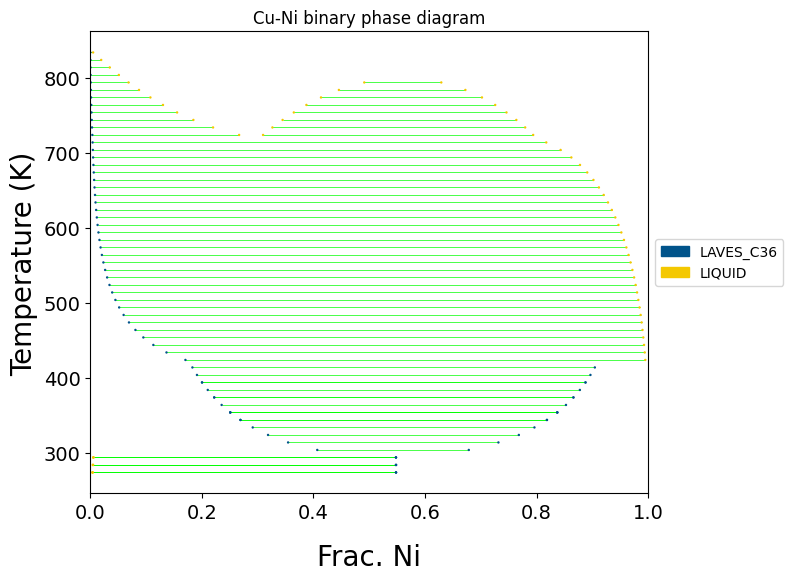

In [57]:
from pycalphad import binplot

legend_handles, color_dict = phase_legend(use_phases)
fig = plt.figure(figsize=(9,6))
axes = fig.gca()

# Plot the phase diagram on the existing axes using the `plot_kwargs={'ax': axes}` keyword argument
binplot(db, ['CU', 'NI'] , use_phases, {v.X('NI'): (0,1,0.01), v.T: (273.5, 1800, 10), v.P:101325}, plot_kwargs={'ax': axes,'tielines':True})

axes.set_xlim(0, 1)
plt.title("Cu-Ni binary phase diagram")
plt.xlabel("Frac. Ni")
plt.show()

So we see the two-phase region exist over a large composition range between say 500-700K. And then below 600K as you increase the composition but drop the temperature the copper rich `LAVES_C36` is the stable structure, till you get to 300K up to about 40% Ni. Then when you cross over to ≥ 65% Ni you get a stable nickel rich `LAVES_C36` structure up to around 450K.

I need to mention this is not an accurate phase diagram for the Cu-Ni system. It should look something like:

![](https://sv.rkriz.net/classes/MSE2094_NoteBook/96ClassProj/OLD/examples/cu_ni.jpg)

The alpha phase in this diagram is the `FCC_A1` structure.

Lets see if we can get closer by including all the phases.

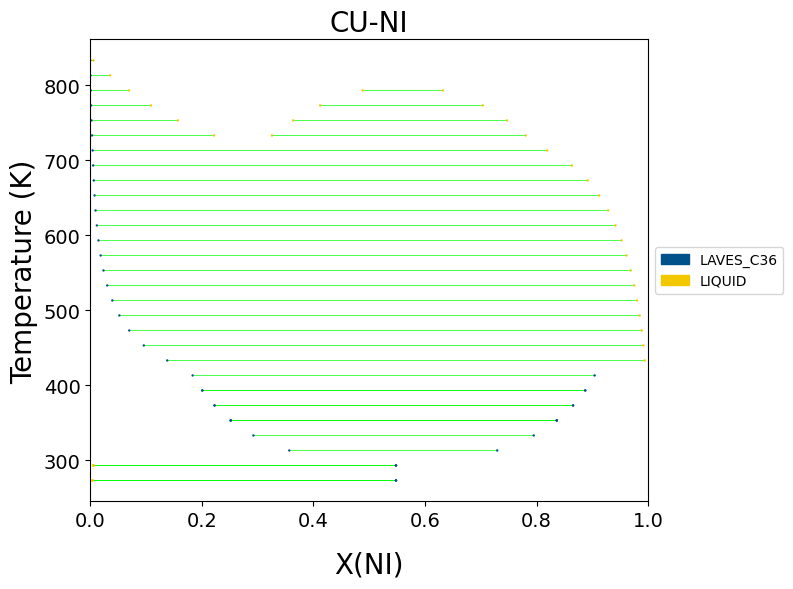

In [37]:
legend_handles, color_dict = phase_legend(cu_ni_phases)
fig = plt.figure(figsize=(9,6))
axes = fig.gca()

# Plot the phase diagram on the existing axes using the `plot_kwargs={'ax': axes}` keyword argument
binplot(db, ['CU', 'NI'] , cu_ni_phases, {v.X('NI'): (0,1,0.01), v.T: (273, 1800, 20), v.P:101325}, plot_kwargs={'ax': axes,'tielines':True})

axes.set_xlim(0, 1)
plt.show()

Also pretty bad!

Lets try another system and `.tdb` to see if it can do any better. I'll focus on the Al-Zn  system. Here is the phase diagram:

![](https://www.researchgate.net/profile/Frank-Goodwin-2/publication/339271686/figure/fig2/AS:858496383848448@1581692896020/Zinc-Al-phase-diagram_W640.jpg)



In [50]:
# Load database and  display phases available
db = Database("cost507.tdb")
phases = db.phases.keys()
cu_ni_phases = [phase for phase in phases if 'AL' in str(db.phases[phase].constituents) and 'ZN' in str(db.phases[phase].constituents)]
print('Phases for the Al-Zn system:')
print(*cu_ni_phases,sep="\n")

Phases for the Al-Zn system:
LIQUID
ALCU_DELTA
ALCU_EPSILON
ALCU_ETA
ALCU_ZETA
ALCUZN_T
ALMG_BETA
ALMG_EPS
ALMG_GAMMA
BCC_A2
BCC_B2
BCT_A5
FCC_A1
DIAMOND_A4
GAMMA_H
HCP_A3
HCP_ZN
LAVES_C14
LAVES_C15
LAVES_C36
MGZN
MG2ZN3
MG2ZN11
PHI
TAU


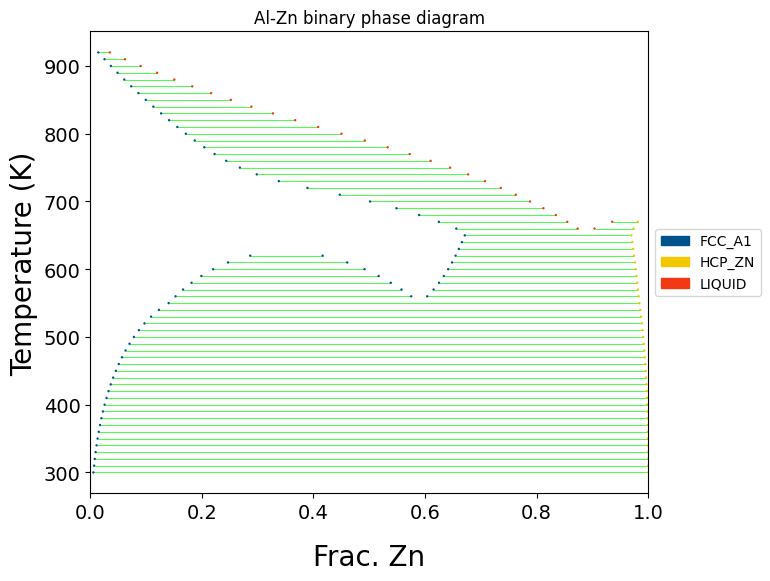

In [56]:
my_phases_alzn = ['LIQUID', 'FCC_A1', 'HCP_A3']

# Create a matplotlib Figure object and get the active Axes
fig = plt.figure(figsize=(9,6))
axes = fig.gca()

# Compute the phase diagram and plot it on the existing axes using the `plot_kwargs={'ax': axes}` keyword argument
binplot(db, ['AL', 'ZN','VA'] , phases, {v.X('ZN'):(0,1,0.02), v.T: (300, 1000, 10), v.P:101325, v.N: 1}, plot_kwargs={'ax': axes})

plt.title("Al-Zn binary phase diagram")
plt.xlabel("Frac. Zn")
plt.show()

Its not too bad! It gets the major phase boundaries correct just not the solid-solution regions btween 60-100%.